In [37]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [38]:
import pandas as pd
import numpy as np
import pyodbc as py

from datetime import date, timedelta, datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE

import keras

pd.set_option('display.max_columns', None)

In [39]:
connection_string = (    
    r'Driver={SQL Server};'
    r'Server=LAPTOP-LD74USH0\SQLEXPRESS;'
    r'Integrated Security=SSPI;'
    r'Trusted_Connection=yes;'
)
pd.set_option('display.max_columns', None)

In [40]:
def sql2df(query, params=[], parse_dates=None, dsn='SQLEXPRESS'):
        with py.connect(connection_string, readonly=True) as conn:
            return pd.read_sql(query, conn, params=params, parse_dates=parse_dates)

In [41]:
# First work with random top 100.000 (to reduce computation time) - 45secs

df = sql2df('''
SELECT TOP 500000 * FROM Seminar.dbo.cleaned_bol_data_full
ORDER BY newid();
''')


In [215]:
# 9.5 minutes 

df = sql2df('''
SELECT * FROM Seminar.dbo.cleaned_bol_data_full;
''')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 78 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   orderDate                         500000 non-null  object        
 1   productId                         500000 non-null  object        
 2   sellerId                          500000 non-null  object        
 3   totalPrice                        500000 non-null  float64       
 4   quantityOrdered                   500000 non-null  int64         
 5   countryCode                       500000 non-null  object        
 6   cancellationDate                  8162 non-null    object        
 7   cancellationReasonCode            8162 non-null    object        
 8   promisedDeliveryDate              500000 non-null  object        
 9   shipmentDate                      491848 non-null  object        
 10  transporterCode                 

In [43]:
#Change type of columns
dtype = {'calculationDefinitive': bool,
         'noCancellation': bool,
         'noCase': bool,
         'hasOneCase': bool,
         'hasMoreCases': bool,
         'noReturn': bool,
         'orderWeekend': bool,
         'orderCorona': bool,
         'countryCodeNL': bool,
         'fulfilmentByBol': bool,
         'countryOriginNL': bool,
         'countryOriginBE': bool,
         'countryOriginDE': bool,
         'orderMonday': bool,
         'orderTuesday': bool,
         'orderWednesday': bool,
         'orderThursday': bool,
         'orderFriday': bool,
         'orderSaturday': bool,
         'orderSunday': bool,
         'orderJanuary': bool,
         'orderFebruary': bool,
         'orderMarch': bool,
         'orderApril': bool,
         'orderMay': bool,
         'orderJune': bool,
         'orderJuly': bool,
         'orderAugust': bool,
         'orderSeptember': bool,
         'orderOctober': bool,
         'orderNovember': bool,
         'orderDecember': bool}

df = df.astype(dtype)

#Transform dates to date-type
df['orderDate'] = pd.to_datetime(df['orderDate'], errors='coerce')
df['cancellationDate'] = pd.to_datetime(df['cancellationDate'], errors='coerce')
df['promisedDeliveryDate'] = pd.to_datetime(df['promisedDeliveryDate'], errors='coerce')
df['shipmentDate'] = pd.to_datetime(df['shipmentDate'], errors='coerce')
df['dateTimeFirstDeliveryMoment'] = pd.to_datetime(df['dateTimeFirstDeliveryMoment'], errors='coerce')
df['startDateCase'] = pd.to_datetime(df['startDateCase'], errors='coerce')
df['returnDateTime'] = pd.to_datetime(df['returnDateTime'], errors='coerce')
df['registrationDateSeller'] = pd.to_datetime(df['registrationDateSeller'], errors='coerce')

df.dtypes

orderDate             datetime64[ns]
productId                     object
sellerId                      object
totalPrice                   float64
quantityOrdered                int64
                           ...      
orderSeptember                  bool
orderOctober                    bool
orderNovember                   bool
orderDecember                   bool
productTitleLength             int64
Length: 78, dtype: object

In [44]:
df.head()

,orderDate,productId,sellerId,totalPrice,quantityOrdered,countryCode,cancellationDate,cancellationReasonCode,promisedDeliveryDate,shipmentDate,transporterCode,transporterName,transporterNameOther,dateTimeFirstDeliveryMoment,fulfilmentType,startDateCase,cntDistinctCaseIds,returnDateTime,quantityReturned,returnCode,productTitle,brickName,chunkName,productGroup,productSubGroup,productSubSubGroup,registrationDateSeller,countryOriginSeller,currentCountryAvailabilitySeller,calculationDefinitive,noCancellation,onTimeDelivery,noCase,hasOneCase,hasMoreCases,noReturn,detailedMatchClassification,generalMatchClassification,determinantClassification,orderYear,orderMonth,orderYearMonth,orderWeekday,orderWeekend,orderCorona,transporterFeature,partnerSellingMonths,cancellationDays,shipmentDays,promisedDeliveryDays,actualDeliveryDays,caseDays,returnDays,countryCodeNL,fulfilmentByBol,countryOriginNL,countryOriginBE,countryOriginDE,orderMonday,orderTuesday,orderWednesday,orderThursday,orderFriday,orderSaturday,orderSunday,orderJanuary,orderFebruary,orderMarch,orderApril,orderMay,orderJune,orderJuly,orderAugust,orderSeptember,orderOctober,orderNovember,orderDecember,productTitleLength
0,2020-04-04,9200000047738664,1055479,29.99,1,NL,NaT,None,2020-04-06,2020-04-06,TNT,PostNL,None,2020-04-07 19:04:43,FBB,NaT,NaN,NaT,NaN,None,Pastelkrijt Faber Castell halve lengte etui � ...,10001677-Artists Pastels/Charcoal/Crayons,Krijt,Recreational and Outdoor Toys,Knutselen,Knutselen,2015-06-17,NL,NL,True,True,false,True,False,False,True,KNOWN MILDLY UNHAPPY,UNHAPPY,Late delivery,2020,04,2020-04,6,True,True,TNT,58,NaN,2.0,2,3.0,NaN,NaN,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,54
1,2019-11-04,9200000065495731,1055479,12.95,1,BE,NaT,None,2019-11-05,2019-11-04,TNT,PostNL,None,2019-11-05 10:12:41,FBB,NaT,NaN,NaT,NaN,None,Snowman - BG-10 whiteboardmarkers - assorti á ...,Pennen (Kantoorbenodigdheden),Stift,Supermarket PG,Schrijfwaren,Stiften,2015-06-17,NL,NL,True,True,true,True,False,False,True,KNOWN HAPPY,KNOWN HAPPY,All good,2019,11,2019-11,1,False,True,TNT,53,NaN,0.0,1,1.0,NaN,NaN,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,69
2,2019-05-10,9200000080483908,1344836,64.95,1,NL,NaT,None,2019-05-11,2019-05-10,TNT,PostNL,None,2019-05-11 09:29:31,FBR,NaT,NaN,NaT,NaN,None,Dyson DC20 telescoopbuis,Schoonmaakapparatuur – Onderdelen/Accessoires,Stofzuiger onderdeel,Household Appliances,Household Appliances Replacement Parts,Household Appliances Replacement Parts,2018-03-22,NL,NL,True,True,true,True,False,False,True,KNOWN HAPPY,KNOWN HAPPY,All good,2019,05,2019-05,5,False,True,TNT,14,NaN,0.0,1,1.0,NaN,NaN,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,24
3,2020-09-23,9200000082961992,888223,67.00,1,NL,NaT,None,2020-09-25,2020-09-25,OTHER,Anders,OTHER,NaT,FBR,NaT,NaN,NaT,NaN,None,Doucheslang Best Design Nero zwart 150 cm,Sanitair/Sanitaire Voorzieningen – Onderdelen/...,Doucheslang,Plumbing and Safety,Badkamer en Sanitair,Douche,2013-12-19,NL,NL,True,True,None,True,False,False,True,UNKNOWN,UNKNOWN,Unknown delivery,2020,09,2020-09,3,False,True,OTHER,81,NaN,2.0,2,NaN,NaN,NaN,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,41
4,2020-12-14,9200000084444615,1263174,12.95,1,NL,NaT,None,2020-12-16,2020-12-15,TNT,PostNL,None,2020-12-16 13:07:20,FBB,NaT,NaN,NaT,NaN,None,Workout Gear - 5 Weerstandsbanden Set - Inclus...,Fitness Accessoires,Weerstandsband,Sporting Equipment,Fitness Klein,Fitnessmaterialen,2017-03-15,NL,NL,True,True,true,True,False,False,True,KNOWN HAPPY,KNOWN HAPPY,All good,2020,12,2020-12,1,False,True,TNT,45,NaN,1.0,2,2.0,NaN,NaN,True,True,True,False,False,True,False,False,False,False,False,False,

#### Add variables

In [45]:
# Binary classification variable
df['binaryMatchClassification'] = df['generalMatchClassification'].apply(lambda x: 'UNKNOWN' if x == 'UNKNOWN' else 'KNOWN')

# Dummy for year = 2020
df['orderYear2020'] = df['orderYear'].apply(lambda x: True if x == 2020 else False)

#### Transporter Groups

In [46]:
def transporterCluster(transporterCode):
    """
    Function to create a new manually clustered transporter variable: 28 -> 5 categories
    """
    if transporterCode in ['AH-NL','TNT','TNT-EXPRESS','TNT-EXTRA']:
        return 'POSTNL'
    elif transporterCode in ['DHL','DHL_DE','DHLFORYOU']:
        return 'DHL'
    elif transporterCode in ['DPD-NL','DPD-BE']:
        return 'DPD'
    elif transporterCode in ['BRIEFPOST','BPOST_BE','BPOST_BRIEF','DHL-GLOBAL-MAIL','TNT_BRIEF']:
        return 'BRIEFPOST'
    else:
        return 'OTHER'

In [47]:
df['transporterCodeGeneral'] = df['transporterCode'].apply(transporterCluster)
df['transporterCodeGeneral'].value_counts()

POSTNL       220877
BRIEFPOST    165089
DHL           45964
DPD           34519
OTHER         33551
Name: transporterCodeGeneral, dtype: int64

#### Product Groups

In [48]:
def productGroupCluster(productGroup):
    """
    Function to create a new manually clustered product group variable based on categories bol.com
    60 -> 14 groups.
    """
    if productGroup in ['Dutch Books PG','Ebooks and Audiobooks','International Books PG']:
        return 'Books'
    elif productGroup in ['Games Accessories','Games Consoles','Games Software Physical',
                          'Movies','Music']:
        return 'Music, Film & Games'
    elif productGroup in ['Camera','Desktop Monitor and Beamer','Ereaders and Accessories',
                          'Laptop Computers','PC Accessories','Personal Audio',
                          'Sound and Vision Accessories','Storage and Network',
                          'Telephone and Tablet Accessories','Telephones and Tablets','Television']:
        return 'Computer & Electronics'
    elif productGroup in ['General Toys','Recreational and Outdoor Toys']:
        return 'Toys & Hobby'
    elif productGroup in ['Baby and Kids Fashion','Baby PG']:
        return 'Baby & Kids'
    elif productGroup in ['Daily Care PG','Health PG','Perfumery PG','Personal Care']:
        return 'Health & Care'
    elif productGroup in ['Footwear','Jewelry and Watches','Mens and Womens Fashion','Wearables']:
        return 'Fashion, Shoes & Accessories'
    elif productGroup in ['Bodyfashion and Beachwear','Camping and Outdoor','Cycling',
                          'Sporting Equipment','Sportswear','Travel Bags and Accessories']:
        return 'Sports, Outdoor & Travel'
    elif productGroup in ['Educational Dutch','Educational International','Printing and Ink']:
        return 'Office & School'
    elif productGroup in ['Supermarket PG'] :
        return 'Food & Beverage'
    elif productGroup in ['Furniture','Heating and Air','Home Decoration','Home Entertainment',
                          'Household','Household Appliances','Kitchen','Kitchen Machines',
                          'Lighting','Major Domestic Appliances PG','Plumbing and Safety']:
        return 'Home, Cooking & Household'
    elif productGroup in ['Garden','Pet PG','Textiles','Tools and Paint']:
        return 'Pets, Garden & Jobs'
    elif productGroup in ['Car and Motorcycle'] :
        return 'Car & Motor'
    else:
        return 'Other'

In [49]:
df['productGroupGeneral'] = df['productGroup'].apply(productGroupCluster)
df['productGroupGeneral'].value_counts()

Computer & Electronics          144912
Home, Cooking & Household        83874
Sports, Outdoor & Travel         54794
Toys & Hobby                     52754
Pets, Garden & Jobs              35573
Health & Care                    31107
Food & Beverage                  27240
Books                            19358
Music, Film & Games              17116
Baby & Kids                      11832
Fashion, Shoes & Accessories     11551
Office & School                   5532
Car & Motor                       3097
Other                             1260
Name: productGroupGeneral, dtype: int64

In [50]:
#Create dummies of new product grouping
for group in df['productGroupGeneral'].unique():
    
    columnName = 'group' + group.split(' ')[0].replace(',','')
    df[columnName] = df['productGroupGeneral'].apply(lambda x: True if x == group else False)

In [51]:
print(df.columns)
print('Total: ',len(df.columns),' columns')

Index(['orderDate', 'productId', 'sellerId', 'totalPrice', 'quantityOrdered',
       'countryCode', 'cancellationDate', 'cancellationReasonCode',
       'promisedDeliveryDate', 'shipmentDate', 'transporterCode',
       'transporterName', 'transporterNameOther',
       'dateTimeFirstDeliveryMoment', 'fulfilmentType', 'startDateCase',
       'cntDistinctCaseIds', 'returnDateTime', 'quantityReturned',
       'returnCode', 'productTitle', 'brickName', 'chunkName', 'productGroup',
       'productSubGroup', 'productSubSubGroup', 'registrationDateSeller',
       'countryOriginSeller', 'currentCountryAvailabilitySeller',
       'calculationDefinitive', 'noCancellation', 'onTimeDelivery', 'noCase',
       'hasOneCase', 'hasMoreCases', 'noReturn', 'detailedMatchClassification',
       'generalMatchClassification', 'determinantClassification', 'orderYear',
       'orderMonth', 'orderYearMonth', 'orderWeekday', 'orderWeekend',
       'orderCorona', 'transporterFeature', 'partnerSellingMonths',
   

#### Functions

In [52]:
def createColumns(df,X):
    """
    Function to create dynamic columns based on the prediction period.
    X = number of days after order date
    """
    
    dynamic_cols = ['caseDays','returnDays','cancellationDays','actualDeliveryDays']
    
    for col in dynamic_cols:
        
        dynamic_colname = col+'_'+str(X)
        df[dynamic_colname] = df[col].dt.days
        df[dynamic_colname] = df[dynamic_colname].apply(lambda x: x if x <= X else None)
        
    return df

In [53]:
def addPeriodColumns(df,X):
    """
    Function to create columns which indicate whether determinants are known after X days.
    Input: X = number of days after order date at which the prediction is made
           df = dataFrame
    TO-DO: add transporter dummies if known after shipmentDate
    """
    
    df['caseKnown']           = df.apply(lambda row: True if row.caseDays <= X else False, axis = 1)
    df['returnKnown']         = df.apply(lambda row: True if row.returnDays <= X else False, axis = 1)
    df['cancellationKnown']   = df.apply(lambda row: True if row.cancellationDays <= X else False, axis = 1)
    df['onTimeDeliveryKnown'] = df.apply(lambda row: True if ((row.actualDeliveryDays <= X) and (row.onTimeDelivery == True)) else False, axis = 1)
    df['lateDeliveryKnown']   = df.apply(lambda row: True if ((row.actualDeliveryDays <= X) and (row.onTimeDelivery == False)) else False, axis = 1)
    
#     df['transporterPostNL'] = df.apply(lambda row: True if ((row.shipmentDays <= X) and (row. == 'PostNL')) else False, axis = 1)
#     df['transporterDHL']    = df.apply(lambda row: True if ((row.shipmentDays <= X) and (row. == 'DHL')) else False, axis = 1)
#     df['transporterGLS']    = df.apply(lambda row: True if ((row.shipmentDays <= X) and (row. == 'GLS')) else False, axis = 1)
#     df['transporterBrief']  = df.apply(lambda row: True if ((row.shipmentDays <= X) and (row. == 'Brief')) else False, axis = 1)
#     df['transporterOther']  = df.apply(lambda row: True if ((row.shipmentDays <= X) and (row. == 'Other')) else False, axis = 1)

    return df

In [54]:
def addProductColumns(df):
    """
    Function to add 4 columns: productOrderCount, productTotalCount, productTotalReturned and productReturnFraction.
    Input: dataFrame with columns: 'productId','orderDate','quantityOrdered','quantityReturned','returnDateTime'.
    """
    df = df.sort_values(by = ['productId','orderDate'])
    df = df.reset_index(drop = True)
    
    df_ = df[['productId','orderDate','quantityOrdered','quantityReturned','returnDateTime']]
    
    #ProductTotalCount
    pivot = df_.groupby(['productId','orderDate']).quantityOrdered.sum().groupby('productId').cumsum()
    productTotalCount = df_.merge(pivot, 
                                left_on=['productId','orderDate'], 
                                right_index=True, 
                                how = 'left').quantityOrdered_y
    
    #ProductOrderCount
    pivot = df_.groupby(['productId','orderDate']).quantityOrdered.count().groupby('productId').cumsum()
    productOrderCount = df_.merge(pivot, 
                                left_on=['productId','orderDate'], 
                                right_index=True, 
                                how = 'left').quantityOrdered_y
    
    #ProductTotalReturned
    productTotalReturned = np.zeros(df_.shape[0])
    
    previousID = None
    
    returnDic = {}
    
    for row in df_.itertuples(): #iterate through dataFrame
        
        if row[0] == 0: 
            
            #update return dictionary if this product is returned
            if row[4] != None:
                if row[5] in returnDic:
                    returnDic[row[5]] += row[4]
                else:
                    returnDic[row[5]] = row[4]

            previousID = row[1]
            
        elif (previousID == row[1]):
            
            #update return dictionary if this product is returned
            if row[4] != None:
                if row[5] in returnDic:
                    returnDic[row[5]] += row[4]
                else:
                    returnDic[row[5]] = row[4]
            
            #add returned products to new dictionary if known
            known = {k: v for k, v in returnDic.items() if k <= row[2]}
            productTotalReturned[row[0]] = sum(known.values())
            
            #update the dictionary by removing the returns which are now known
            returnDic = {k: v for k, v in returnDic.items() if k > row[2]}
                        
            previousID = row[1]
            
        else:
            returnDic = {} #new productId, hence empty the return dictionary
            
            #update return dictionary if this product is returned
            if row[4] != None:
                if row[5] in returnDic:
                    returnDic[row[5]] += row[4]
                else:
                    returnDic[row[5]] = row[4]
                    
            previousID = row[1]
    
    df_['productTotalReturned'] = productTotalReturned
    pivot = df_.groupby(by = ['productId','orderDate']).productTotalReturned.sum().groupby('productId').cumsum()
    productTotalReturned = df_.merge(pivot, 
                                left_on=['productId','orderDate'], 
                                right_index=True, 
                                how = 'left').productTotalReturned_y
     
    #Add new columns to dataFrame    
    df['productOrderCount'] = productOrderCount
    df['productTotalCount'] = productTotalCount
    df['productTotalReturned'] = productTotalReturned
    df['productReturnFraction'] = productTotalReturned / productTotalCount
    
    return(df)

In [62]:
def classifyLabels(classifier, X, y, n, split = 'TimeSeries', smote = False, scale = None, days = 0):
    """
    Function to classify match labels using a pre-specified classifier with X and y variables. 
    
    Input:
    - classifier: can be any supported classifier. E.g. DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth=10). Necessary!
    - X: dataframe input on explanatory features. Necessary!
    - y: dataframe input on labels. Necessary!
    - n: number of folds to be evaluated.
    - split: object that can take value 'Random' to make K-fold random train/test split. Default is to apply time series split.
    - smote: boolean, if true Synthetic Minority Oversampling will be applied. Default = False.
    - scale: object that can take values 'MinMax' or 'Standard' to scale X correspondingly. Any other input will not scale X. Default = None.
    - days: integer number of days after orderDate that should be considered. Default = 0.
    
    Output: 
    - accuracy: list of accuracies for the n evaluated classifiers.
    - class_report: report of performance measures for the n evaluated classifiers.
    """
    
    accuracy = {}
    class_report = {}
    count = 1
    
    if split == 'Random':
        
        kf = StratifiedKFold(n_splits = n, random_state = 0, shuffle = True)
        for train_index, test_index in kf.split(X, y):

            if scale == 'MinMax':
                scaler = preprocessing.MinMaxScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            elif scale == 'Standard':
                scaler = preprocessing.StandardScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            else:
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if smote == True:
                smote = SMOTE('not majority')
                X_train, y_train = smote.fit_sample(X_train,y_train)
            else:
                X_train, y_train = X_train, y_train
            
            clf = classifier
            clf = clf.fit(X_train,y_train)
            prediction = clf.predict(X_test)
            accuracy[count] = metrics.accuracy_score(y_test, prediction)
            class_report[count] = metrics.classification_report(y_test, prediction)
    
            print(count)
            count +=1
    
    else:
        
        tscv = TimeSeriesSplit(n_splits = n)
        
        for train_index, test_index in tscv.split(X):
        
            if scale == 'MinMax':
                scaler = preprocessing.MinMaxScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            elif scale == 'Standard':
                scaler = preprocessing.StandardScaler()
                X_scaled = pd.DataFrame(scaler.fit_transform(X))
                X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            else:
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if smote == True:
                smote = SMOTE('not majority')
                X_train, y_train = smote.fit_sample(X_train,y_train)
            else:
                X_train, y_train = X_train, y_train
            
            clf = classifier
            clf = clf.fit(X_train,y_train)
            prediction = clf.predict(X_test)
            accuracy[count] = metrics.accuracy_score(y_test, prediction)
            class_report[count] = metrics.classification_report(y_test, prediction)
    
            print(count)
            count +=1

    return(accuracy, class_report)

In [56]:
df = addProductColumns(df)

<ipython-input-54-5e0d7d48eabf>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['productTotalReturned'] = productTotalReturned


In [57]:
df = addPeriodColumns(df,2)

In [58]:
#Categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['productId', 'sellerId', 'countryCode', 'cancellationReasonCode', 'transporterCode', 'transporterName', 'transporterNameOther', 'fulfilmentType', 'returnCode', 'productTitle', 'brickName', 'chunkName', 'productGroup', 'productSubGroup', 'productSubSubGroup', 'countryOriginSeller', 'currentCountryAvailabilitySeller', 'onTimeDelivery', 'detailedMatchClassification', 'generalMatchClassification', 'determinantClassification', 'orderMonth', 'orderYearMonth', 'transporterFeature', 'binaryMatchClassification', 'transporterCodeGeneral', 'productGroupGeneral']


# Function-based Classification

## Define X and y variables for classification

In [59]:
index = ['orderDate']
X_col = ['totalPrice','quantityOrdered','promisedDeliveryDays','orderCorona','partnerSellingMonths',
        'countryCodeNL', 'fulfilmentByBol', 'countryOriginNL', 'countryOriginBE', 'countryOriginDE', 'orderWeekend',
        'orderMonday','orderTuesday', 'orderWednesday', 'orderThursday', 'orderFriday', 'orderSaturday', 'orderSunday',
        'orderJanuary', 'orderFebruary', 'orderMarch', 'orderApril', 'orderMay', 'orderJune', 'orderJuly',
        'orderAugust', 'orderSeptember', 'orderOctober', 'orderNovember', 'orderDecember', 'productTitleLength',
        'productOrderCount', 'productReturnFraction', 'orderYear2020', 'groupComputer', 'groupFood', 'groupBooks',
        'groupHealth', 'groupToys', 'groupSports', 'groupHome', 'groupOffice', 'groupPets', 'groupMusic', 'groupFashion',
        'groupBaby', 'groupOther', 'groupCar']
y_col = ['binaryMatchClassification']
#y_col = ['generalMatchClassification']

df_test = df[index+X_col+y_col].dropna()
df_test = df_test.sort_values(by = 'orderDate')
df_test = df_test.reset_index(drop = True)

X = df_test[X_col]
y = df_test[y_col]

## Classification

In [64]:
# Naive Bayes Bernoulli
(accuracy,class_report) = classifyLabels(BernoulliNB(), X, y, 3)
print(accuracy)
for item in class_report.values():
    print(item)

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3
{1: 0.757824, 2: 0.784864, 3: 0.764312}
              precision    recall  f1-score   support

       KNOWN       0.86      0.77      0.81     83632
     UNKNOWN       0.61      0.74      0.67     41368

    accuracy                           0.76    125000
   macro avg       0.73      0.75      0.74    125000
weighted avg       0.78      0.76      0.76    125000

              precision    recall  f1-score   support

       KNOWN       0.81      0.92      0.86     90425
     UNKNOWN       0.68      0.42      0.52     34575

    accuracy                           0.78    125000
   macro avg       0.74      0.67      0.69    125000
weighted avg       0.77      0.78      0.77    125000

              precision    recall  f1-score   support

       KNOWN       0.77      0.93      0.84     84783
     UNKNOWN       0.73      0.42      0.54     40217

    accuracy                           0.76    125000
   macro avg       0.75      0.67      0.69    125000
weighted avg       0.76      0.7

# Binary Classification

**Define X and y variables for binary classification**

In [23]:
index = ['orderDate']
X_col = ['totalPrice','quantityOrdered','promisedDeliveryDays','orderCorona','partnerSellingMonths',
        'countryCodeNL', 'fulfilmentByBol', 'countryOriginNL', 'countryOriginBE', 'countryOriginDE', 'orderWeekend',
        'orderMonday','orderTuesday', 'orderWednesday', 'orderThursday', 'orderFriday', 'orderSaturday', 'orderSunday',
        'orderJanuary', 'orderFebruary', 'orderMarch', 'orderApril', 'orderMay', 'orderJune', 'orderJuly',
        'orderAugust', 'orderSeptember', 'orderOctober', 'orderNovember', 'orderDecember', 'productTitleLength',
        'productOrderCount', 'productReturnFraction', 'orderYear2020', 'groupComputer', 'groupFood', 'groupBooks',
        'groupHealth', 'groupToys', 'groupSports', 'groupHome', 'groupOffice', 'groupPets', 'groupMusic', 'groupFashion',
        'groupBaby', 'groupOther', 'groupCar']
y_col = ['binaryMatchClassification']

df_test = df[index+X_col+y_col].dropna()
df_test = df_test.sort_values(by = 'orderDate')
df_test = df_test.reset_index(drop = True)

X_binary = df_test[X_col]
y_binary = df_test[y_col]

In [24]:
df['binaryMatchClassification'].value_counts()

KNOWN      68181
UNKNOWN    31819
Name: binaryMatchClassification, dtype: int64

#### SMOTE Definition

In [25]:
smote = SMOTE('not majority')
X_sm, y_sm = smote.fit_sample(X_binary,y_binary)
print(X_binary.shape, y_binary.shape)
print(X_sm.shape, y_sm.shape)

C:\Users\thoma\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


(100000, 48) (100000, 1)
(136362, 48) (136362, 1)


# Multi-class Classification

#### Define X and y variables for multi-class classification

In [128]:
index = ['orderDate']
X_col = ['totalPrice','quantityOrdered','promisedDeliveryDays','orderCorona','partnerSellingMonths',
        'countryCodeNL', 'fulfilmentByBol', 'countryOriginNL', 'countryOriginBE', 'countryOriginDE', 'orderWeekend',
        'orderMonday','orderTuesday', 'orderWednesday', 'orderThursday', 'orderFriday', 'orderSaturday', 'orderSunday',
        'orderJanuary', 'orderFebruary', 'orderMarch', 'orderApril', 'orderMay', 'orderJune', 'orderJuly',
        'orderAugust', 'orderSeptember', 'orderOctober', 'orderNovember', 'orderDecember', 'productTitleLength',
        'productOrderCount', 'productReturnFraction', 'orderYear2020']
y_col = ['generalMatchClassification']

df_test = df[index+X_col+y_col].dropna()
df_test = df_test.sort_values(by = 'orderDate')
df_test = df_test.reset_index(drop = True)

X_multi = df_test[X_col]
y_multi = df_test[y_col]

### SMOTE Definition

In [138]:
smote = SMOTE('not majority')
X_sm, y_sm = smote.fit_sample(X_multi,y_multi)
print(X_multi.shape, y_multi.shape)
print(X_sm.shape, y_sm.shape)

C:\Users\thoma\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=not majority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


(100000, 34) (100000, 1)
(168363, 34) (168363, 1)


## Naive Bayes

### Regular Train/Test Split

#### Stratified K-fold

In [235]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    #scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    #X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    #X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    #clf = GaussianNB()
    clf = BernoulliNB()
    
    clf = clf.fit(X_train,y_train)
    
    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [236]:
print(accuracy_K)

{1: 0.7795358092853228, 2: 0.7798964539533106, 3: 0.7793037386320282}


In [237]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.80      0.91      0.85   1085101
     UNKNOWN       0.72      0.50      0.59    505883

    accuracy                           0.78   1590984
   macro avg       0.76      0.70      0.72   1590984
weighted avg       0.77      0.78      0.77   1590984

              precision    recall  f1-score   support

       KNOWN       0.80      0.91      0.85   1085101
     UNKNOWN       0.72      0.50      0.59    505882

    accuracy                           0.78   1590983
   macro avg       0.76      0.70      0.72   1590983
weighted avg       0.77      0.78      0.77   1590983

              precision    recall  f1-score   support

       KNOWN       0.80      0.91      0.85   1085100
     UNKNOWN       0.72      0.50      0.59    505883

    accuracy                           0.78   1590983
   macro avg       0.76      0.70      0.72   1590983
weighted avg       0.77      0.78      0.77   1590983



#### SMOTE Stratified K-fold

In [194]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    #scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    #X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    #X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = GaussianNB()
    #clf = BernoulliNB()
    
    clf = clf.fit(X_train_sm,y_train_sm)
    
    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [190]:
print(accuracy_K)

{1: 0.7794744105117898, 2: 0.7816578165781658, 3: 0.7799477994779948}


In [171]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.75      0.81     22700
     UNKNOWN       0.59      0.76      0.66     10634

    accuracy                           0.75     33334
   macro avg       0.73      0.75      0.73     33334
weighted avg       0.78      0.75      0.76     33334

              precision    recall  f1-score   support

       KNOWN       0.86      0.76      0.81     22699
     UNKNOWN       0.60      0.74      0.66     10634

    accuracy                           0.76     33333
   macro avg       0.73      0.75      0.74     33333
weighted avg       0.78      0.76      0.76     33333

              precision    recall  f1-score   support

       KNOWN       0.86      0.76      0.81     22699
     UNKNOWN       0.59      0.74      0.66     10634

    accuracy                           0.75     33333
   macro avg       0.73      0.75      0.73     33333
weighted avg       0.77      0.75      0.76     33333



### Time Series Split

#### Basic

In [238]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    #scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    #X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    #X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    #clf = GaussianNB()
    clf = BernoulliNB()
    
    clf = clf.fit(X_train,y_train)
    
    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [239]:
print(accuracy)

{1: 0.7535426742549888, 2: 0.7869350346997286, 3: 0.7640669875305577}


In [240]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.85      0.76      0.80    796906
     UNKNOWN       0.61      0.74      0.67    396331

    accuracy                           0.75   1193237
   macro avg       0.73      0.75      0.74   1193237
weighted avg       0.77      0.75      0.76   1193237

              precision    recall  f1-score   support

       KNOWN       0.81      0.92      0.86    865973
     UNKNOWN       0.68      0.43      0.52    327264

    accuracy                           0.79   1193237
   macro avg       0.74      0.68      0.69   1193237
weighted avg       0.77      0.79      0.77   1193237

              precision    recall  f1-score   support

       KNOWN       0.77      0.92      0.84    809326
     UNKNOWN       0.73      0.43      0.54    383911

    accuracy                           0.76   1193237
   macro avg       0.75      0.68      0.69   1193237
weighted avg       0.76      0.76      0.74   1193237



#### SMOTE

In [205]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    #scaler = preprocessing.StandardScaler()
    #scaler = preprocessing.MinMaxScaler()
    #X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    #X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    #clf = GaussianNB()
    clf = BernoulliNB()
    
    clf = clf.fit(X_train_sm,y_train_sm)
    
    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [206]:
print(accuracy)

{1: 0.76504, 2: 0.75272, 3: 0.7532}


In [207]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.83      0.81      0.82     16740
     UNKNOWN       0.64      0.68      0.66      8260

    accuracy                           0.77     25000
   macro avg       0.74      0.74      0.74     25000
weighted avg       0.77      0.77      0.77     25000

              precision    recall  f1-score   support

       KNOWN       0.88      0.77      0.82     18081
     UNKNOWN       0.54      0.72      0.62      6919

    accuracy                           0.75     25000
   macro avg       0.71      0.74      0.72     25000
weighted avg       0.78      0.75      0.76     25000

              precision    recall  f1-score   support

       KNOWN       0.88      0.74      0.80     16853
     UNKNOWN       0.59      0.78      0.67      8147

    accuracy                           0.75     25000
   macro avg       0.73      0.76      0.74     25000
weighted avg       0.78      0.75      0.76     25000



## K-NN

### Regular Train/Test Split

#### Stratified K-fold

In [ ]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = neighbors.KNeighborsClassifier(n_neighbors = 3)
    
    clf = clf.fit(X_train,y_train)
    
    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

<ipython-input-241-f03717b703b4>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf = clf.fit(X_train,y_train)


In [26]:
print(accuracy_K)

{1: 0.7836743265134697, 2: 0.7825278252782528, 3: 0.7875078750787508}


In [27]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.84      0.84      0.84     22729
     UNKNOWN       0.66      0.65      0.66     10605

    accuracy                           0.78     33334
   macro avg       0.75      0.75      0.75     33334
weighted avg       0.78      0.78      0.78     33334

              precision    recall  f1-score   support

       KNOWN       0.84      0.84      0.84     22728
     UNKNOWN       0.66      0.65      0.66     10605

    accuracy                           0.78     33333
   macro avg       0.75      0.75      0.75     33333
weighted avg       0.78      0.78      0.78     33333

              precision    recall  f1-score   support

       KNOWN       0.84      0.85      0.85     22728
     UNKNOWN       0.67      0.65      0.66     10605

    accuracy                           0.79     33333
   macro avg       0.76      0.75      0.75     33333
weighted avg       0.79      0.79      0.79     33333



#### SMOTE Stratified K-fold

In [ ]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = neighbors.KNeighborsClassifier(n_neighbors = 5)
    
    clf = clf.fit(X_train_sm,y_train_sm)
    
    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

In [ ]:
print(accuracy_K)

In [ ]:
for item in class_report_K.values():
    print(item)

### Time Series Split

#### Basic

In [319]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = neighbors.KNeighborsClassifier(n_neighbors = 10)
    
    clf = clf.fit(X_train,y_train)
    
    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

<ipython-input-319-7424c65b413a>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf = clf.fit(X_train,y_train)


1


<ipython-input-319-7424c65b413a>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf = clf.fit(X_train,y_train)


2


<ipython-input-319-7424c65b413a>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf = clf.fit(X_train,y_train)


3


In [320]:
print(accuracy)

{1: 0.78656, 2: 0.78268, 3: 0.766}


In [321]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.82      0.88      0.85     16683
     UNKNOWN       0.71      0.61      0.65      8317

    accuracy                           0.79     25000
   macro avg       0.76      0.74      0.75     25000
weighted avg       0.78      0.79      0.78     25000

              precision    recall  f1-score   support

       KNOWN       0.82      0.89      0.86     18270
     UNKNOWN       0.62      0.48      0.55      6730

    accuracy                           0.78     25000
   macro avg       0.72      0.69      0.70     25000
weighted avg       0.77      0.78      0.77     25000

              precision    recall  f1-score   support

       KNOWN       0.79      0.89      0.84     16881
     UNKNOWN       0.69      0.51      0.59      8119

    accuracy                           0.77     25000
   macro avg       0.74      0.70      0.71     25000
weighted avg       0.76      0.77      0.76     25000



#### SMOTE

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = neighbors.KNeighborsClassifier(n_neighbors = 10)
    
    clf = clf.fit(X_train_sm,y_train_sm)
    
    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

In [ ]:
print(accuracy)

In [ ]:
for item in class_report.values():
    print(item)

## Logistic Regression

### Regular Train/Test Split

#### Stratified K-fold

In [28]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]

    clf = LogisticRegression(random_state=0,
                             class_weight='balanced',
                             fit_intercept=False,
                             #max_iter=1000,
                             solver='liblinear')

    clf = clf.fit(X_train, y_train)

    prediction = clf.predict(X_test)

    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [29]:
print(accuracy_K)

{1: 0.7411951760964781, 2: 0.7377673776737768, 3: 0.7453274532745328}


In [30]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.92      0.68      0.78     22729
     UNKNOWN       0.56      0.88      0.68     10605

    accuracy                           0.74     33334
   macro avg       0.74      0.78      0.73     33334
weighted avg       0.81      0.74      0.75     33334

              precision    recall  f1-score   support

       KNOWN       0.92      0.67      0.78     22728
     UNKNOWN       0.56      0.87      0.68     10605

    accuracy                           0.74     33333
   macro avg       0.74      0.77      0.73     33333
weighted avg       0.80      0.74      0.75     33333

              precision    recall  f1-score   support

       KNOWN       0.92      0.68      0.78     22728
     UNKNOWN       0.56      0.88      0.69     10605

    accuracy                           0.75     33333
   macro avg       0.74      0.78      0.74     33333
weighted avg       0.81      0.75      0.75     33333



#### SMOTE Stratified K-fold

In [265]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]

    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = LogisticRegression(random_state=0,
                             class_weight='balanced',
                             fit_intercept=False,
                             #max_iter=1000,
                             solver='liblinear')

    clf = clf.fit(X_train_sm, y_train_sm)

    prediction = clf.predict(X_test)

    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [266]:
print(accuracy_K)

{1: 0.7404451910961781, 2: 0.7398373983739838, 3: 0.7432874328743287}


In [267]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.92      0.68      0.78     22775
     UNKNOWN       0.56      0.87      0.68     10559

    accuracy                           0.74     33334
   macro avg       0.74      0.78      0.73     33334
weighted avg       0.80      0.74      0.75     33334

              precision    recall  f1-score   support

       KNOWN       0.92      0.68      0.78     22775
     UNKNOWN       0.56      0.87      0.68     10558

    accuracy                           0.74     33333
   macro avg       0.74      0.77      0.73     33333
weighted avg       0.80      0.74      0.75     33333

              precision    recall  f1-score   support

       KNOWN       0.92      0.68      0.78     22775
     UNKNOWN       0.56      0.87      0.68     10558

    accuracy                           0.74     33333
   macro avg       0.74      0.78      0.73     33333
weighted avg       0.81      0.74      0.75     33333



### Time Series Split

#### Basic

In [289]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = LogisticRegression(random_state=0,
                             class_weight='balanced',
                             fit_intercept=False,
                             #max_iter=1000,
                             solver='liblinear')

    clf = clf.fit(X_train, y_train)

    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [290]:
print(accuracy)

{1: 0.74276, 2: 0.76068, 3: 0.77056}


In [291]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.89      0.70      0.78     16683
     UNKNOWN       0.58      0.83      0.68      8317

    accuracy                           0.74     25000
   macro avg       0.74      0.76      0.73     25000
weighted avg       0.79      0.74      0.75     25000

              precision    recall  f1-score   support

       KNOWN       0.88      0.78      0.83     18270
     UNKNOWN       0.54      0.71      0.61      6730

    accuracy                           0.76     25000
   macro avg       0.71      0.74      0.72     25000
weighted avg       0.79      0.76      0.77     25000

              precision    recall  f1-score   support

       KNOWN       0.91      0.73      0.81     16881
     UNKNOWN       0.60      0.85      0.71      8119

    accuracy                           0.77     25000
   macro avg       0.76      0.79      0.76     25000
weighted avg       0.81      0.77      0.78     25000



#### SMOTE

In [298]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = LogisticRegression(random_state=0,
                             class_weight='balanced',
                             fit_intercept=False,
                             #max_iter=1000,
                             solver='liblinear')

    clf = clf.fit(X_train_sm, y_train_sm)

    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [299]:
print(accuracy)

{1: 0.74192, 2: 0.76148, 3: 0.76888}


In [300]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.90      0.69      0.78     16683
     UNKNOWN       0.58      0.84      0.68      8317

    accuracy                           0.74     25000
   macro avg       0.74      0.77      0.73     25000
weighted avg       0.79      0.74      0.75     25000

              precision    recall  f1-score   support

       KNOWN       0.88      0.78      0.83     18270
     UNKNOWN       0.54      0.71      0.62      6730

    accuracy                           0.76     25000
   macro avg       0.71      0.74      0.72     25000
weighted avg       0.79      0.76      0.77     25000

              precision    recall  f1-score   support

       KNOWN       0.92      0.72      0.81     16881
     UNKNOWN       0.60      0.86      0.71      8119

    accuracy                           0.77     25000
   macro avg       0.76      0.79      0.76     25000
weighted avg       0.81      0.77      0.78     25000



## SVM

### Regular Train/Test Split

#### Stratified K-fold

In [34]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):
    
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = svm.SVC(random_state=0,
                  class_weight='balanced')
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [35]:
print(accuracy_K)

{1: 0.7343853122937541, 2: 0.7319473194731947, 3: 0.7403174031740317}


In [36]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.92      0.67      0.77     22729
     UNKNOWN       0.55      0.88      0.68     10605

    accuracy                           0.73     33334
   macro avg       0.74      0.77      0.73     33334
weighted avg       0.80      0.73      0.74     33334

              precision    recall  f1-score   support

       KNOWN       0.92      0.67      0.77     22728
     UNKNOWN       0.55      0.88      0.68     10605

    accuracy                           0.73     33333
   macro avg       0.73      0.77      0.72     33333
weighted avg       0.80      0.73      0.74     33333

              precision    recall  f1-score   support

       KNOWN       0.93      0.67      0.78     22728
     UNKNOWN       0.56      0.89      0.68     10605

    accuracy                           0.74     33333
   macro avg       0.74      0.78      0.73     33333
weighted avg       0.81      0.74      0.75     33333



#### SMOTE Stratified K-fold

In [ ]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):
    
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = svm.SVC(random_state=0,
                  class_weight='balanced')
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

In [ ]:
print(accuracy_K)

In [ ]:
for item in class_report_K.values():
    print(item)

### Time Series Split

#### Basic

In [37]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = svm.SVC(random_state=0,
                  class_weight='balanced')

    clf = clf.fit(X_train, y_train)

    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [38]:
print(accuracy)

{1: 0.769, 2: 0.77168, 3: 0.79004}


In [39]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.76      0.82     16686
     UNKNOWN       0.62      0.78      0.69      8314

    accuracy                           0.77     25000
   macro avg       0.75      0.77      0.75     25000
weighted avg       0.79      0.77      0.77     25000

              precision    recall  f1-score   support

       KNOWN       0.91      0.76      0.83     18079
     UNKNOWN       0.56      0.80      0.66      6921

    accuracy                           0.77     25000
   macro avg       0.73      0.78      0.74     25000
weighted avg       0.81      0.77      0.78     25000

              precision    recall  f1-score   support

       KNOWN       0.93      0.75      0.83     17027
     UNKNOWN       0.62      0.87      0.73      7973

    accuracy                           0.79     25000
   macro avg       0.77      0.81      0.78     25000
weighted avg       0.83      0.79      0.80     25000



#### SMOTE

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):
    
    #scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_binary))

    #X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    #y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = svm.SVC(kernel='linear',
                  random_state=0,
                  class_weight='balanced')

    clf = clf.fit(X_train_sm, y_train_sm)

    prediction = clf.predict(X_test)

    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

In [ ]:
print(accuracy)

In [ ]:
for item in class_report.values():
    print(item)

## Decision Tree

### Regular Train/Test Split

#### Stratified K-fold

In [184]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = DecisionTreeClassifier(random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

1
2
3


In [186]:
print(accuracy_K)

{1: 0.8220135597288054, 2: 0.8199381993819939, 3: 0.8185281852818528}


In [185]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.87      0.87     22677
     UNKNOWN       0.72      0.72      0.72     10657

    accuracy                           0.82     33334
   macro avg       0.80      0.79      0.79     33334
weighted avg       0.82      0.82      0.82     33334

              precision    recall  f1-score   support

       KNOWN       0.87      0.86      0.87     22676
     UNKNOWN       0.71      0.73      0.72     10657

    accuracy                           0.82     33333
   macro avg       0.79      0.80      0.79     33333
weighted avg       0.82      0.82      0.82     33333

              precision    recall  f1-score   support

       KNOWN       0.87      0.86      0.87     22676
     UNKNOWN       0.71      0.73      0.72     10657

    accuracy                           0.82     33333
   macro avg       0.79      0.79      0.79     33333
weighted avg       0.82      0.82      0.82     33333



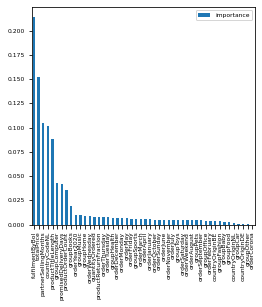

In [172]:
plt.rcParams.update({'font.size': 6})
importanceDF = pd.DataFrame(clf.feature_importances_,index=X_col,columns=['importance']).sort_values('importance',ascending=False)
importanceDF.plot.bar(figsize=(4,4))
plt.show()

#### SMOTE Stratified K-fold

In [187]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = DecisionTreeClassifier(random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

1
2
3


In [188]:
print(accuracy_K)

{1: 0.8215335693286134, 2: 0.8167281672816729, 3: 0.8174181741817418}


In [189]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.88      0.86      0.87     22677
     UNKNOWN       0.71      0.74      0.73     10657

    accuracy                           0.82     33334
   macro avg       0.79      0.80      0.80     33334
weighted avg       0.82      0.82      0.82     33334

              precision    recall  f1-score   support

       KNOWN       0.87      0.86      0.86     22676
     UNKNOWN       0.71      0.73      0.72     10657

    accuracy                           0.82     33333
   macro avg       0.79      0.79      0.79     33333
weighted avg       0.82      0.82      0.82     33333

              precision    recall  f1-score   support

       KNOWN       0.87      0.86      0.86     22676
     UNKNOWN       0.71      0.74      0.72     10657

    accuracy                           0.82     33333
   macro avg       0.79      0.80      0.79     33333
weighted avg       0.82      0.82      0.82     33333



### Time Series Split

#### Basic

In [190]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = DecisionTreeClassifier(random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

1
2
3


In [191]:
print(accuracy)

{1: 0.72532, 2: 0.71684, 3: 0.73688}


In [192]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.81      0.77      0.79     16663
     UNKNOWN       0.58      0.63      0.61      8337

    accuracy                           0.73     25000
   macro avg       0.69      0.70      0.70     25000
weighted avg       0.73      0.73      0.73     25000

              precision    recall  f1-score   support

       KNOWN       0.83      0.77      0.80     18105
     UNKNOWN       0.49      0.58      0.53      6895

    accuracy                           0.72     25000
   macro avg       0.66      0.68      0.66     25000
weighted avg       0.74      0.72      0.72     25000

              precision    recall  f1-score   support

       KNOWN       0.80      0.81      0.81     16999
     UNKNOWN       0.59      0.58      0.59      8001

    accuracy                           0.74     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.74      0.74      0.74     25000



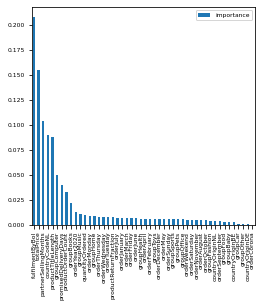

In [175]:
plt.rcParams.update({'font.size': 6})
importanceDF = pd.DataFrame(clf.feature_importances_,index=X_col,columns=['importance']).sort_values('importance',ascending=False)
importanceDF.plot.bar(figsize=(4,4))
plt.show()

#### SMOTE

In [193]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = DecisionTreeClassifier(random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    #prediction = clf.predict(X_train)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    #accuracy[count] = metrics.accuracy_score(y_train, prediction)
    #class_report[count] = metrics.classification_report(y_train, prediction)
    
    print(count)
    count += 1

1
2
3


In [194]:
print(accuracy)

{1: 0.72532, 2: 0.71684, 3: 0.73688}


In [195]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.81      0.77      0.79     16663
     UNKNOWN       0.58      0.63      0.61      8337

    accuracy                           0.73     25000
   macro avg       0.69      0.70      0.70     25000
weighted avg       0.73      0.73      0.73     25000

              precision    recall  f1-score   support

       KNOWN       0.83      0.77      0.80     18105
     UNKNOWN       0.49      0.58      0.53      6895

    accuracy                           0.72     25000
   macro avg       0.66      0.68      0.66     25000
weighted avg       0.74      0.72      0.72     25000

              precision    recall  f1-score   support

       KNOWN       0.80      0.81      0.81     16999
     UNKNOWN       0.59      0.58      0.59      8001

    accuracy                           0.74     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.74      0.74      0.74     25000



## AdaBoost

### Regular Train/Test Split

#### Stratified K-fold

In [77]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                             n_estimators=50,
                             random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [78]:
print(accuracy_K)

{1: 0.8507829843403132, 2: 0.8465184651846518, 3: 0.8521885218852189}


In [79]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.88      0.90      0.89     22729
     UNKNOWN       0.78      0.74      0.76     10605

    accuracy                           0.85     33334
   macro avg       0.83      0.82      0.83     33334
weighted avg       0.85      0.85      0.85     33334

              precision    recall  f1-score   support

       KNOWN       0.88      0.90      0.89     22728
     UNKNOWN       0.77      0.73      0.75     10605

    accuracy                           0.85     33333
   macro avg       0.83      0.82      0.82     33333
weighted avg       0.84      0.85      0.85     33333

              precision    recall  f1-score   support

       KNOWN       0.89      0.90      0.89     22728
     UNKNOWN       0.78      0.75      0.76     10605

    accuracy                           0.85     33333
   macro avg       0.83      0.83      0.83     33333
weighted avg       0.85      0.85      0.85     33333



#### SMOTE Stratified K-fold

In [80]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                             n_estimators=50,
                             random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [81]:
print(accuracy_K)

{1: 0.8507829843403132, 2: 0.8465184651846518, 3: 0.8521885218852189}


In [82]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.88      0.90      0.89     22729
     UNKNOWN       0.78      0.74      0.76     10605

    accuracy                           0.85     33334
   macro avg       0.83      0.82      0.83     33334
weighted avg       0.85      0.85      0.85     33334

              precision    recall  f1-score   support

       KNOWN       0.88      0.90      0.89     22728
     UNKNOWN       0.77      0.73      0.75     10605

    accuracy                           0.85     33333
   macro avg       0.83      0.82      0.82     33333
weighted avg       0.84      0.85      0.85     33333

              precision    recall  f1-score   support

       KNOWN       0.89      0.90      0.89     22728
     UNKNOWN       0.78      0.75      0.76     10605

    accuracy                           0.85     33333
   macro avg       0.83      0.83      0.83     33333
weighted avg       0.85      0.85      0.85     33333



### Time Series Split

#### Basic

In [92]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                             n_estimators=50,
                             random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [93]:
print(accuracy)

{1: 0.79208, 2: 0.80636, 3: 0.81316}


In [94]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.84      0.85      0.84     16686
     UNKNOWN       0.69      0.68      0.69      8314

    accuracy                           0.79     25000
   macro avg       0.77      0.76      0.77     25000
weighted avg       0.79      0.79      0.79     25000

              precision    recall  f1-score   support

       KNOWN       0.86      0.87      0.87     18079
     UNKNOWN       0.66      0.63      0.64      6921

    accuracy                           0.81     25000
   macro avg       0.76      0.75      0.76     25000
weighted avg       0.80      0.81      0.81     25000

              precision    recall  f1-score   support

       KNOWN       0.84      0.90      0.87     17027
     UNKNOWN       0.75      0.63      0.68      7973

    accuracy                           0.81     25000
   macro avg       0.79      0.76      0.77     25000
weighted avg       0.81      0.81      0.81     25000



#### SMOTE

In [89]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                             n_estimators=50,
                             random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [90]:
print(accuracy)

{1: 0.80912, 2: 0.82736, 3: 0.82136}


In [91]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.86      0.86      0.86     16686
     UNKNOWN       0.71      0.71      0.71      8314

    accuracy                           0.81     25000
   macro avg       0.79      0.78      0.78     25000
weighted avg       0.81      0.81      0.81     25000

              precision    recall  f1-score   support

       KNOWN       0.87      0.90      0.88     18079
     UNKNOWN       0.71      0.64      0.67      6921

    accuracy                           0.83     25000
   macro avg       0.79      0.77      0.78     25000
weighted avg       0.82      0.83      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.84      0.91      0.87     17027
     UNKNOWN       0.77      0.62      0.69      7973

    accuracy                           0.82     25000
   macro avg       0.81      0.77      0.78     25000
weighted avg       0.82      0.82      0.82     25000



## Gradient Boosting

### Regular Train/Test Split

#### Stratified K-fold

In [102]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):
    
    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = GradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [103]:
print(accuracy)

{1: 0.79208, 2: 0.80636, 3: 0.81316}


In [104]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.86      0.92      0.89     22729
     UNKNOWN       0.79      0.67      0.73     10605

    accuracy                           0.84     33334
   macro avg       0.82      0.80      0.81     33334
weighted avg       0.84      0.84      0.84     33334

              precision    recall  f1-score   support

       KNOWN       0.86      0.92      0.89     22728
     UNKNOWN       0.79      0.68      0.73     10605

    accuracy                           0.84     33333
   macro avg       0.82      0.80      0.81     33333
weighted avg       0.84      0.84      0.84     33333

              precision    recall  f1-score   support

       KNOWN       0.86      0.92      0.89     22728
     UNKNOWN       0.80      0.68      0.74     10605

    accuracy                           0.84     33333
   macro avg       0.83      0.80      0.81     33333
weighted avg       0.84      0.84      0.84     33333



#### SMOTE Stratified K-fold

In [105]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):
    
    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = GradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [106]:
print(accuracy_K)

{1: 0.8224635507289855, 2: 0.8209882098820989, 3: 0.8256082560825608}


In [107]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.87      0.87     22729
     UNKNOWN       0.72      0.71      0.72     10605

    accuracy                           0.82     33334
   macro avg       0.80      0.79      0.79     33334
weighted avg       0.82      0.82      0.82     33334

              precision    recall  f1-score   support

       KNOWN       0.87      0.87      0.87     22728
     UNKNOWN       0.72      0.72      0.72     10605

    accuracy                           0.82     33333
   macro avg       0.79      0.79      0.79     33333
weighted avg       0.82      0.82      0.82     33333

              precision    recall  f1-score   support

       KNOWN       0.87      0.87      0.87     22728
     UNKNOWN       0.73      0.72      0.72     10605

    accuracy                           0.83     33333
   macro avg       0.80      0.80      0.80     33333
weighted avg       0.83      0.83      0.83     33333



### Time Series Split

#### Basic

In [108]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = GradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [109]:
print(accuracy)

{1: 0.8276, 2: 0.83684, 3: 0.82904}


In [110]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.86      0.89      0.87     16686
     UNKNOWN       0.76      0.70      0.73      8314

    accuracy                           0.83     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.83      0.83      0.83     25000

              precision    recall  f1-score   support

       KNOWN       0.86      0.92      0.89     18079
     UNKNOWN       0.76      0.61      0.67      6921

    accuracy                           0.84     25000
   macro avg       0.81      0.77      0.78     25000
weighted avg       0.83      0.84      0.83     25000

              precision    recall  f1-score   support

       KNOWN       0.84      0.93      0.88     17027
     UNKNOWN       0.80      0.62      0.70      7973

    accuracy                           0.83     25000
   macro avg       0.82      0.77      0.79     25000
weighted avg       0.83      0.83      0.82     25000



#### SMOTE

In [111]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = GradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [112]:
print(accuracy)

{1: 0.8238, 2: 0.82588, 3: 0.82192}


In [113]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.87      0.87     16686
     UNKNOWN       0.74      0.73      0.73      8314

    accuracy                           0.82     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.82      0.82      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.86      0.90      0.88     18079
     UNKNOWN       0.71      0.63      0.67      6921

    accuracy                           0.83     25000
   macro avg       0.79      0.77      0.77     25000
weighted avg       0.82      0.83      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.86      0.89      0.87     17027
     UNKNOWN       0.74      0.68      0.71      7973

    accuracy                           0.82     25000
   macro avg       0.80      0.78      0.79     25000
weighted avg       0.82      0.82      0.82     25000



## Hist Gradient Boosting

### Regular Train/Test Split

#### Stratified K-fold

In [116]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):
    
    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = HistGradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [117]:
print(accuracy_K)

{1: 0.8607427851442971, 2: 0.8621186211862119, 3: 0.8657786577865779}


In [118]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.89      0.91      0.90     22729
     UNKNOWN       0.80      0.75      0.77     10605

    accuracy                           0.86     33334
   macro avg       0.84      0.83      0.84     33334
weighted avg       0.86      0.86      0.86     33334

              precision    recall  f1-score   support

       KNOWN       0.89      0.92      0.90     22728
     UNKNOWN       0.81      0.75      0.78     10605

    accuracy                           0.86     33333
   macro avg       0.85      0.83      0.84     33333
weighted avg       0.86      0.86      0.86     33333

              precision    recall  f1-score   support

       KNOWN       0.89      0.92      0.90     22728
     UNKNOWN       0.81      0.75      0.78     10605

    accuracy                           0.87     33333
   macro avg       0.85      0.84      0.84     33333
weighted avg       0.86      0.87      0.86     33333



#### SMOTE Stratified K-fold

In [119]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):
    
    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = HistGradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [120]:
print(accuracy_K)

{1: 0.8533629327413452, 2: 0.8526685266852668, 3: 0.8579785797857978}


In [121]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.88      0.90      0.89     22729
     UNKNOWN       0.78      0.75      0.76     10605

    accuracy                           0.85     33334
   macro avg       0.83      0.82      0.83     33334
weighted avg       0.85      0.85      0.85     33334

              precision    recall  f1-score   support

       KNOWN       0.88      0.90      0.89     22728
     UNKNOWN       0.78      0.75      0.76     10605

    accuracy                           0.85     33333
   macro avg       0.83      0.82      0.83     33333
weighted avg       0.85      0.85      0.85     33333

              precision    recall  f1-score   support

       KNOWN       0.89      0.91      0.90     22728
     UNKNOWN       0.79      0.76      0.77     10605

    accuracy                           0.86     33333
   macro avg       0.84      0.83      0.83     33333
weighted avg       0.86      0.86      0.86     33333



### Time Series Split

#### Basic

In [122]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = HistGradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [123]:
print(accuracy)

{1: 0.83876, 2: 0.84388, 3: 0.83832}


In [124]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.90      0.88     16686
     UNKNOWN       0.78      0.72      0.75      8314

    accuracy                           0.84     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.84      0.84      0.84     25000

              precision    recall  f1-score   support

       KNOWN       0.87      0.92      0.89     18079
     UNKNOWN       0.75      0.65      0.70      6921

    accuracy                           0.84     25000
   macro avg       0.81      0.78      0.80     25000
weighted avg       0.84      0.84      0.84     25000

              precision    recall  f1-score   support

       KNOWN       0.85      0.93      0.89     17027
     UNKNOWN       0.80      0.65      0.72      7973

    accuracy                           0.84     25000
   macro avg       0.83      0.79      0.80     25000
weighted avg       0.84      0.84      0.83     25000



#### SMOTE

In [125]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = HistGradientBoostingClassifier(random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [126]:
print(accuracy)

{1: 0.83468, 2: 0.84392, 3: 0.80312}


In [127]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.89      0.88     16686
     UNKNOWN       0.77      0.72      0.74      8314

    accuracy                           0.83     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.83      0.83      0.83     25000

              precision    recall  f1-score   support

       KNOWN       0.88      0.91      0.89     18079
     UNKNOWN       0.74      0.67      0.70      6921

    accuracy                           0.84     25000
   macro avg       0.81      0.79      0.80     25000
weighted avg       0.84      0.84      0.84     25000

              precision    recall  f1-score   support

       KNOWN       0.91      0.79      0.85     17027
     UNKNOWN       0.65      0.83      0.73      7973

    accuracy                           0.80     25000
   macro avg       0.78      0.81      0.79     25000
weighted avg       0.83      0.80      0.81     25000



## Bagging

### Regular Train/Test Split

#### Stratified K-fold

In [55]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = BaggingClassifier(n_estimators=10,
                              random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [56]:
print(accuracy_K)

{1: 0.8623027539449211, 2: 0.8649686496864969, 3: 0.8668886688866889}


In [57]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.88      0.92      0.90     22729
     UNKNOWN       0.81      0.74      0.77     10605

    accuracy                           0.86     33334
   macro avg       0.85      0.83      0.84     33334
weighted avg       0.86      0.86      0.86     33334

              precision    recall  f1-score   support

       KNOWN       0.88      0.92      0.90     22728
     UNKNOWN       0.82      0.74      0.78     10605

    accuracy                           0.86     33333
   macro avg       0.85      0.83      0.84     33333
weighted avg       0.86      0.86      0.86     33333

              precision    recall  f1-score   support

       KNOWN       0.88      0.93      0.90     22728
     UNKNOWN       0.82      0.74      0.78     10605

    accuracy                           0.87     33333
   macro avg       0.85      0.83      0.84     33333
weighted avg       0.86      0.87      0.86     33333



#### SMOTE Stratified K-fold

In [58]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = BaggingClassifier(n_estimators=10,
                              random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [59]:
print(accuracy_K)

{1: 0.8623027539449211, 2: 0.8649686496864969, 3: 0.8668886688866889}


In [60]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.88      0.92      0.90     22729
     UNKNOWN       0.81      0.74      0.77     10605

    accuracy                           0.86     33334
   macro avg       0.85      0.83      0.84     33334
weighted avg       0.86      0.86      0.86     33334

              precision    recall  f1-score   support

       KNOWN       0.88      0.92      0.90     22728
     UNKNOWN       0.82      0.74      0.78     10605

    accuracy                           0.86     33333
   macro avg       0.85      0.83      0.84     33333
weighted avg       0.86      0.86      0.86     33333

              precision    recall  f1-score   support

       KNOWN       0.88      0.93      0.90     22728
     UNKNOWN       0.82      0.74      0.78     10605

    accuracy                           0.87     33333
   macro avg       0.85      0.83      0.84     33333
weighted avg       0.86      0.87      0.86     33333



### Time Series Split

#### Basic

In [61]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = BaggingClassifier(n_estimators=10,
                            random_state=0)
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [62]:
print(accuracy)

{1: 0.82344, 2: 0.81772, 3: 0.80748}


In [63]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.85      0.89      0.87     16686
     UNKNOWN       0.76      0.68      0.72      8314

    accuracy                           0.82     25000
   macro avg       0.81      0.79      0.80     25000
weighted avg       0.82      0.82      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.86      0.90      0.88     18079
     UNKNOWN       0.69      0.61      0.65      6921

    accuracy                           0.82     25000
   macro avg       0.78      0.75      0.76     25000
weighted avg       0.81      0.82      0.81     25000

              precision    recall  f1-score   support

       KNOWN       0.84      0.89      0.86     17027
     UNKNOWN       0.73      0.63      0.68      7973

    accuracy                           0.81     25000
   macro avg       0.78      0.76      0.77     25000
weighted avg       0.80      0.81      0.80     25000



#### SMOTE

In [64]:
#TIME-SERIES SPLIT

tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = BaggingClassifier(n_estimators=10,
                            random_state=0)
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


1


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


2


C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


3


In [65]:
print(accuracy)

{1: 0.82344, 2: 0.81772, 3: 0.80748}


In [66]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.85      0.89      0.87     16686
     UNKNOWN       0.76      0.68      0.72      8314

    accuracy                           0.82     25000
   macro avg       0.81      0.79      0.80     25000
weighted avg       0.82      0.82      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.86      0.90      0.88     18079
     UNKNOWN       0.69      0.61      0.65      6921

    accuracy                           0.82     25000
   macro avg       0.78      0.75      0.76     25000
weighted avg       0.81      0.82      0.81     25000

              precision    recall  f1-score   support

       KNOWN       0.84      0.89      0.86     17027
     UNKNOWN       0.73      0.63      0.68      7973

    accuracy                           0.81     25000
   macro avg       0.78      0.76      0.77     25000
weighted avg       0.80      0.81      0.80     25000



## Random Forest

### Regular Train/Test Split

#### Stratified K-fold

In [196]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    clf = RandomForestClassifier(n_estimators=10,
                                 random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

<ipython-input-196-1b643471391a>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


1


<ipython-input-196-1b643471391a>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


2


<ipython-input-196-1b643471391a>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


3


In [197]:
print(accuracy_K)

{1: 0.8565728685426292, 2: 0.8521885218852189, 3: 0.8536285362853628}


In [198]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.93      0.90     22677
     UNKNOWN       0.82      0.70      0.76     10657

    accuracy                           0.86     33334
   macro avg       0.85      0.82      0.83     33334
weighted avg       0.85      0.86      0.85     33334

              precision    recall  f1-score   support

       KNOWN       0.87      0.92      0.89     22676
     UNKNOWN       0.81      0.70      0.75     10657

    accuracy                           0.85     33333
   macro avg       0.84      0.81      0.82     33333
weighted avg       0.85      0.85      0.85     33333

              precision    recall  f1-score   support

       KNOWN       0.87      0.92      0.90     22676
     UNKNOWN       0.81      0.70      0.75     10657

    accuracy                           0.85     33333
   macro avg       0.84      0.81      0.83     33333
weighted avg       0.85      0.85      0.85     33333



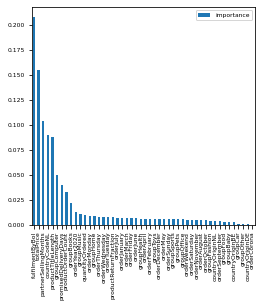

In [178]:
plt.rcParams.update({'font.size': 6})
importanceDF = pd.DataFrame(clf.feature_importances_,index=X_col,columns=['importance']).sort_values('importance',ascending=False)
importanceDF.plot.bar(figsize=(4,4))
plt.show()

#### SMOTE Stratified K-fold

In [199]:
kf = StratifiedKFold(n_splits = 3, random_state = 0, shuffle = True)

accuracy_K = {}
class_report_K = {}
count = 1

for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = RandomForestClassifier(n_estimators=10,
                                 random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy_K[count] = metrics.accuracy_score(y_test, prediction)
    class_report_K[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

<ipython-input-199-b640dbf5c81e>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


1


<ipython-input-199-b640dbf5c81e>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


2


<ipython-input-199-b640dbf5c81e>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


3


In [200]:
print(accuracy_K)

{1: 0.8565728685426292, 2: 0.8521885218852189, 3: 0.8536285362853628}


In [201]:
for item in class_report_K.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.87      0.93      0.90     22677
     UNKNOWN       0.82      0.70      0.76     10657

    accuracy                           0.86     33334
   macro avg       0.85      0.82      0.83     33334
weighted avg       0.85      0.86      0.85     33334

              precision    recall  f1-score   support

       KNOWN       0.87      0.92      0.89     22676
     UNKNOWN       0.81      0.70      0.75     10657

    accuracy                           0.85     33333
   macro avg       0.84      0.81      0.82     33333
weighted avg       0.85      0.85      0.85     33333

              precision    recall  f1-score   support

       KNOWN       0.87      0.92      0.90     22676
     UNKNOWN       0.81      0.70      0.75     10657

    accuracy                           0.85     33333
   macro avg       0.84      0.81      0.83     33333
weighted avg       0.85      0.85      0.85     33333



### Time Series Split

#### Basic

In [202]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
     
    clf = RandomForestClassifier(n_estimators=10,
                                 random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

<ipython-input-202-e181d623384f>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


1


<ipython-input-202-e181d623384f>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


2


<ipython-input-202-e181d623384f>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


3


In [203]:
print(accuracy)

{1: 0.82024, 2: 0.83024, 3: 0.82256}


In [180]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.84      0.90      0.87     16663
     UNKNOWN       0.77      0.66      0.71      8337

    accuracy                           0.82     25000
   macro avg       0.80      0.78      0.79     25000
weighted avg       0.82      0.82      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.85      0.93      0.89     18105
     UNKNOWN       0.76      0.57      0.65      6895

    accuracy                           0.83     25000
   macro avg       0.80      0.75      0.77     25000
weighted avg       0.82      0.83      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.82      0.94      0.88     16999
     UNKNOWN       0.82      0.57      0.67      8001

    accuracy                           0.82     25000
   macro avg       0.82      0.76      0.78     25000
weighted avg       0.82      0.82      0.81     25000



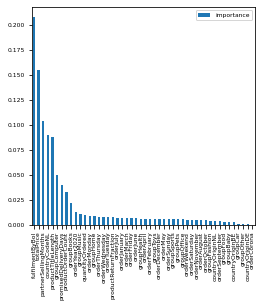

In [181]:
plt.rcParams.update({'font.size': 6})
importanceDF = pd.DataFrame(clf.feature_importances_,index=X_col,columns=['importance']).sort_values('importance',ascending=False)
importanceDF.plot.bar(figsize=(4,4))
plt.show()

#### SMOTE

In [204]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

for train_index, test_index in tscv.split(X_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    X_train_sm, y_train_sm = smote.fit_sample(X_train,y_train)
    
    clf = RandomForestClassifier(n_estimators=10,
                                 random_state=0,
                                 class_weight='balanced')
    
    clf = clf.fit(X_train_sm,y_train_sm)

    prediction = clf.predict(X_test)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count +=1

<ipython-input-204-1cf78784fc00>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


1


<ipython-input-204-1cf78784fc00>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


2


<ipython-input-204-1cf78784fc00>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf = rfclf.fit(X_train,y_train)


3


In [ ]:
print(accuracy)

In [164]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       KNOWN       0.84      0.90      0.87     16663
     UNKNOWN       0.77      0.66      0.71      8337

    accuracy                           0.82     25000
   macro avg       0.80      0.78      0.79     25000
weighted avg       0.82      0.82      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.85      0.93      0.89     18105
     UNKNOWN       0.76      0.57      0.65      6895

    accuracy                           0.83     25000
   macro avg       0.80      0.75      0.77     25000
weighted avg       0.82      0.83      0.82     25000

              precision    recall  f1-score   support

       KNOWN       0.82      0.94      0.88     16999
     UNKNOWN       0.82      0.57      0.67      8001

    accuracy                           0.82     25000
   macro avg       0.82      0.76      0.78     25000
weighted avg       0.82      0.82      0.81     25000



# Not Yet Working: Neural Network

In [208]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical

In [209]:
model = Sequential()
model.add(Dense(12, input_dim=31, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))
opt = SGD(lr=0.01, momentum=0.9)

In [210]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [211]:
for train_index, test_index in kf.split(X_binary, y_binary):

    X_train, X_test = X_binary.iloc[train_index], X_binary.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]
    
    model_fit = model.fit(X_train, y_train, epochs=100, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

#### Tests & Checks

In [10]:
(df['startDateCase'] - df['orderDate']).dt.days

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
99995   NaN
99996   NaN
99997   NaN
99998   NaN
99999   NaN
Length: 100000, dtype: float64

In [25]:
import math
for x in range(1000):
    if np.isnan(df['caseDays'].iloc[x]) == False:
        print(df[['startDateCase','orderDate','caseDays']].iloc[x])
        print((df['startDateCase'] - df['orderDate']).dt.days.iloc[x])

startDateCase    2019-12-11 00:00:00
orderDate        2019-11-28 00:00:00
caseDays                        13.0
Name: 33, dtype: object
13.0
startDateCase    2020-04-17 00:00:00
orderDate        2020-04-14 00:00:00
caseDays                         3.0
Name: 41, dtype: object
3.0
startDateCase    2020-05-26 00:00:00
orderDate        2020-05-24 00:00:00
caseDays                         2.0
Name: 47, dtype: object
2.0
startDateCase    2020-04-13 00:00:00
orderDate        2020-04-07 00:00:00
caseDays                         6.0
Name: 74, dtype: object
6.0
startDateCase    2019-12-10 00:00:00
orderDate        2019-12-03 00:00:00
caseDays                         7.0
Name: 79, dtype: object
7.0
startDateCase    2020-07-02 00:00:00
orderDate        2020-06-29 00:00:00
caseDays                         3.0
Name: 86, dtype: object
3.0
startDateCase    2020-02-18 00:00:00
orderDate        2020-01-23 00:00:00
caseDays                        26.0
Name: 106, dtype: object
26.0
startDateCase    2020-04

In [21]:
df[['orderDate','productId']].iloc[1]

orderDate    2020-06-01 00:00:00
productId       9200000079850193
Name: 1, dtype: object